# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Get Data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.08 MiB/s, done.
Updating files: 100% (13/13), done.
pubmed-rct  sample_data


In [3]:
# Check what's inside the ubmed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


## Import Necessary Libraries

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
import tensorflow as tf

In [6]:
import os
import random

In [7]:
# se out the target directory
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
# Find out filenames in the target directory
filenames = [data_dir + fn for fn in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize 

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [9]:
def get_lines(filename):
  """
  Reads the passed text file.
  args:
        file name (file location)
  return:
          List of strings
  """

  with open(filename, "r") as f:
    return f.readlines()

In [10]:
# 
train_lines = get_lines(data_dir+"train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [12]:
def preprocess_text_data(filename):
  """
  Returns list of dictionaries of abstract line data

  Takes in file name, reads it contents and sorts through each line
  and extracting data
  """

  input_lines = get_lines(filename)  # get all the lines from the file
  abstract_lines = ""                # create an empty abstract
  abstract_samples = []                 # create an empty abstarct list

  # loop through each line of input lines
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""            # reset the abstract lines to null

    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines() # split abstract into lines

      # Iterate through each line in a single abstract and count them at them at the same time
      for line_number, line in enumerate(abstract_lines_split):
        line_data = {}
        target_text_splits = line.split("\t")            # split target label from text
        line_data["line_number"] = line_number
        line_data["target"] = target_text_splits[0]
        line_data["text"] = target_text_splits[1].lower()
        line_data["total_lines"] = len(abstract_lines_split) - 1

        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


In [13]:
%%time

train_samples = preprocess_text_data(data_dir+"train.txt")
test_samples = preprocess_text_data(data_dir+"test.txt")
val_samples = preprocess_text_data(data_dir+"dev.txt")
len(train_samples), len(test_samples), len(val_samples)

CPU times: user 435 ms, sys: 104 ms, total: 539 ms
Wall time: 543 ms


(180040, 30135, 30212)

In [14]:
train_samples[:11]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [15]:
# Create a dataFrame
train_df = pd.DataFrame(data=train_samples)
test_df = pd.DataFrame(data=test_samples)
val_df = pd.DataFrame(data=val_samples)
print(len(train_df), len(test_df), len(val_df))

180040 30135 30212


In [16]:
train_df

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
...,...,...,...,...
180035,7,RESULTS,for the absolute change in percent atheroma vo...,11
180036,8,RESULTS,"for pav , a significantly greater percentage o...",11
180037,9,RESULTS,both strategies had acceptable side effect pro...,11
180038,10,CONCLUSIONS,"compared with standard statin monotherapy , th...",11


In [17]:
# Check target distribution
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

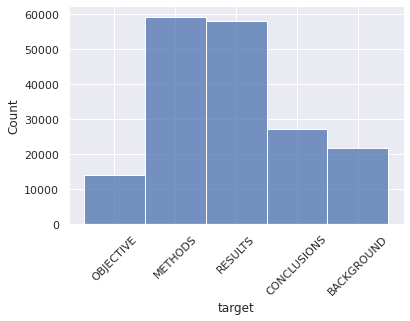

In [18]:
fig, ax = plt.subplots(1,)
sns.histplot(data=train_df["target"], ax=ax)
plt.xticks(rotation=45);

In [19]:
train_list = train_df["text"].to_list()
test_list = test_df["text"].to_list()
val_list = val_df["text"].to_list()
print(len(train_list), len(test_list), len(val_list))

180040 30135 30212


In [20]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [21]:
oneHotEncoder = OneHotEncoder(sparse=False)

train_labels_encoded = oneHotEncoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_labels_encoded = oneHotEncoder.transform(test_df["target"].to_numpy().reshape(-1,1))
val_labels_encoded = oneHotEncoder.transform(val_df["target"].to_numpy().reshape(-1,1))  

In [22]:
train_labels_encoded[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [23]:
labelEncoder = LabelEncoder()

train_label_encoded = labelEncoder.fit_transform(train_df["target"].to_numpy())
test_label_encoded = labelEncoder.transform(test_df["target"].to_numpy())
val_label_encoded = labelEncoder.transform(val_df["target"].to_numpy())


In [24]:
train_label_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [25]:
num_classes = len(labelEncoder.classes_)
classes = labelEncoder.classes_
print(num_classes, classes)


5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Model: 0

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
model_0 = Pipeline([
    ("tdf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_list,
            y=train_label_encoded)

Pipeline(steps=[('tdf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
model_0.score(X=val_list, 
              y=val_label_encoded)

0.7218323844829869

In [29]:
preds_0 = model_0.predict(val_list)

In [160]:
model_0_results = model_evaluation(val_label_encoded,preds_0)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Get helper functions

In [30]:
!wget https://raw.githubusercontent.com/Shakhthi/Deep-Learning/main/NLP_helper.py

--2023-02-21 11:30:25--  https://raw.githubusercontent.com/Shakhthi/Deep-Learning/main/NLP_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1796 (1.8K) [text/plain]
Saving to: ‘NLP_helper.py’

NLP_helper.py       100%[===================>]   1.75K  --.-KB/s    in 0s      

2023-02-21 11:30:25 (26.1 MB/s) - ‘NLP_helper.py’ saved [1796/1796]



In [31]:
from NLP_helper import model_evaluation

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [33]:
precision, recall, fscore, _ = precision_recall_fscore_support(val_label_encoded, preds_0, average="weighted")
accuracy = accuracy_score(val_label_encoded, preds_0)

results_0 = {"accuracy": accuracy,
             "precision": precision,
             "recall": recall,
             "f1": fscore}

results_0

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [34]:
train_list[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [35]:
# Average length of each sentence
seq = [len(sentence.split()) for sentence in train_list]
mean_seq = np.mean(seq)
round(mean_seq)

26

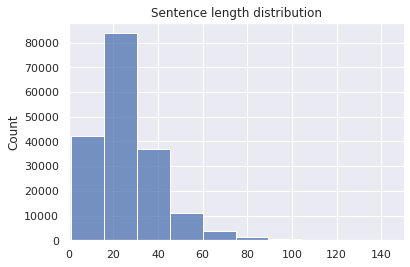

In [36]:
# what's distribution looks like?
sns.histplot(data=seq, bins=20).set(xlim=[0,150], title="Sentence length distribution");

In [37]:
# How long of a sentence length covers 95% of the example?
output_seq_len = int(np.percentile(seq,95))
output_seq_len

55

In [38]:
# Max sequence length
max(seq)

296

### Create a text vectorizer layer

In [39]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [40]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [41]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    standardize="lower_and_strip_punctuation",
                                    output_sequence_length=output_seq_len)

In [42]:
text_vectorizer.adapt(data=train_list)

In [91]:
# Test text vectorizer with random sentences
ran_sen = random.choice(train_list)
print(f"Text:\n {ran_sen}")
print(f"\nText Length: {len(ran_sen)}")
print(f"\nVectorized text:\n {text_vectorizer(ran_sen)}")

Text:
 decreased sbp from baseline in group t was significantly more than group v in each period of time ( d@-d@ ) .

Text Length: 109

Vectorized text:
 [ 212 1353   27   49    5   13  206   10   39   69   42   13 1010    5
  122  173    4   63 5295    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [44]:
# vocublary
rct_20k_voc = text_vectorizer.get_vocabulary()
print(f"Total words in vocublary: {len(rct_20k_voc)}")
print(f"\nMost used words: {rct_20k_voc[:5]}")
print(f"\nRare words: {rct_20k_voc[-5:]}")

Total words in vocublary: 64841

Most used words: ['', '[UNK]', 'the', 'and', 'of']

Rare words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [45]:
# get the config of our vocublary
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create custom text embedding

In [46]:
# Create token embedding layer
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_voc), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [47]:
# Show example embedding
target = random.choice(train_list)
print(f"Sentence before vectorization:\n {target}\n")
vectorized_sentence = text_vectorizer([target])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the primary focus was on parent-child communication and parenting .

Sentence after vectorization (before embedding):
 [[   2   56 1620   10   18 6164 1118    3 2361    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.0264903   0.02264548  0.00254557 ... -0.03881316  0.04242659
   -0.03290551]
  [ 0.01204866  0.039046    0.03391108 ...  0.03245914  0.00327549
   -0.04678243]
  [-0.01676785 -0.04899194 -0.00979203 ...  0.02747417  0.03692638
    0.02116362]
  ...
  [ 0.03616513 -0.00529052  0.03906159 ... -0.00913716 -0.04120224
    0.03017734]
  [ 0.03616513 -0.00529052  0.03906159 ... -0.00913716 -0.04120224
    0.03017734]
  [ 0.03616513 -0.00529052  0.03906159 ... -0.00913716 -0.04120224
    0.03017734]]]

Embedded sentence shape: (1, 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [48]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_list, train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_list, test_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_list, val_labels_encoded))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [49]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [50]:
from tensorflow.keras import layers

In [51]:
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
tokenizer = text_vectorizer(inputs)
embed_layer = token_embed(tokenizer)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embed_layer)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [52]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [53]:
meta_1 = model_1.fit(train_dataset,
                     epochs=3,
                     steps_per_epoch=int(0.1*len(train_dataset)),
                     validation_data=val_dataset,
                     validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 70s 122ms/step - loss: 0.9104 - accuracy: 0.6379 - val_loss: 0.6820 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 70s 124ms/step - loss: 0.6544 - accuracy: 0.7582 - val_loss: 0.6284 - val_accuracy: 0.7766
Epoch 3/3
562/562 [==============================] - 68s 122ms/step - loss: 0.6149 - accuracy: 0.7749 - val_loss: 0.5956 - val_accuracy: 0.7842


In [54]:
# Ealuate the model with whole dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.5973 - accuracy: 0.7869


[0.5972809195518494, 0.7868727445602417]

In [55]:
# predict using validation data
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 6s 6ms/step


array([[4.2223665e-01, 1.7733593e-01, 7.8182168e-02, 2.9499778e-01,
        2.7247366e-02],
       [4.6824405e-01, 2.5148869e-01, 1.3504659e-02, 2.5904709e-01,
        7.7154795e-03],
       [1.4571844e-01, 7.1330681e-03, 1.6453972e-03, 8.4545344e-01,
        4.9618571e-05],
       ...,
       [2.9719313e-06, 5.7050469e-04, 4.8638397e-04, 2.2259605e-06,
        9.9893790e-01],
       [5.3063221e-02, 4.5562655e-01, 1.1483826e-01, 6.9704518e-02,
        3.0676740e-01],
       [1.5639782e-01, 7.2176236e-01, 3.5098229e-02, 4.0977206e-02,
        4.5764368e-02]], dtype=float32)

In [56]:
model_1_pred_probs.shape

(30212, 5)

In [57]:
# Finding actual classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [163]:
# calculate the model_1 results
model_1_results = model_evaluation(y_true=val_label_encoded, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.68727657884284,
 'precision': 0.7843143971684529,
 'recall': 0.7868727657884285,
 'f1': 0.7844727964635236}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [59]:
import tensorflow_hub as hub

In [60]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universel_sentence_encoder")

In [61]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_list)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 airway clearance was rapid .
Setence after embedding:
[-0.04104412  0.0345123  -0.02114217 -0.00443053  0.02315692  0.03038928
  0.05150878  0.01161177  0.03736468  0.0037066   0.04874158  0.04804878
  0.01917106  0.01546416  0.07745621  0.00918392 -0.00476587  0.03079107
  0.01373504  0.04353774 -0.06582095  0.01134654 -0.070399   -0.0766352
 -0.06790205 -0.06742305  0.00695762  0.06017877 -0.08291661  0.03157558]

Length of sentence embedding: 512


In [62]:
# Building the feature extractor model
inputs = layers.Input(shape=[], dtype=tf.string) 
use = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(use)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_feature_extractor")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [63]:
# compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = "Adam",
                metrics = ["accuracy"])

In [64]:
model_2.summary()

Model: "model_2_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universel_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [65]:
meta_2 = model_2.fit(train_dataset,
                     epochs=3,
                     steps_per_epoch=int(0.1 * len(train_dataset)),
                     validation_data=val_dataset,
                     validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9137 - accuracy: 0.6500 - val_loss: 0.7971 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7688 - accuracy: 0.7020 - val_loss: 0.7541 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7516 - accuracy: 0.7121 - val_loss: 0.7379 - val_accuracy: 0.7158


In [66]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7408 - accuracy: 0.7139


[0.7408429384231567, 0.7138554453849792]

In [67]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.3885186 , 0.40185115, 0.00239986, 0.20001437, 0.00721597],
       [0.32078037, 0.50973356, 0.00404615, 0.16236731, 0.00307268],
       [0.22762004, 0.13427076, 0.01743694, 0.5778438 , 0.04282848],
       ...,
       [0.0014298 , 0.00615514, 0.04623485, 0.00095319, 0.945227  ],
       [0.00377997, 0.04075925, 0.2076691 , 0.00181588, 0.74597585],
       [0.17986862, 0.20124069, 0.5557921 , 0.00586789, 0.05723066]],
      dtype=float32)

In [68]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [162]:
model_2_results = model_evaluation(val_label_encoded, model_2_preds)
model_2_results

{'accuracy': 71.3855421686747,
 'precision': 0.7144500935530809,
 'recall': 0.713855421686747,
 'f1': 0.7110513009378274}

In [70]:
result_1

{'accuracy': 78.68727657884284,
 'precision': 0.7843143971684529,
 'recall': 0.7868727657884285,
 'f1': 0.7844727964635236}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings. 

### Creating a character-level tokenizer

In [71]:
train_list[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [72]:
# Make a funcion to split chars
def split_chars(text):
  return " ".join(list(text))

split_chars(train_list[4])

's e c o n d a r y   o u t c o m e   m e a s u r e s   i n c l u d e d   t h e   w e s t e r n   o n t a r i o   a n d   m c m a s t e r   u n i v e r s i t i e s   o s t e o a r t h r i t i s   i n d e x   s c o r e s   ,   p a t i e n t   g l o b a l   a s s e s s m e n t   (   p g a   )   o f   t h e   s e v e r i t y   o f   k n e e   o a   ,   a n d   @ - m i n   w a l k   d i s t a n c e   (   @ m w d   )   .'

In [73]:
# split sequence-level data splits in character-level data splits
train_chars = [split_chars(sentence) for sentence in train_list]
test_chars = [split_chars(sentence) for sentence in test_list]
val_chars = [split_chars(sentence) for sentence in val_list]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [74]:
# what's the average character length?
char_len = [len(i) for i in train_list]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

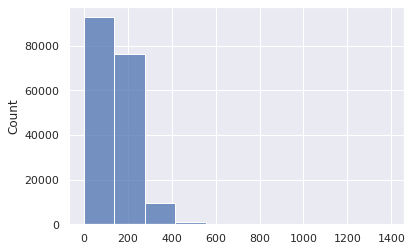

In [75]:
# Check the distribution of our sequences at character level
sns.histplot(data=char_len, bins=10)

In [76]:
# Find what character length covers 95% of sequences
out_seq_char_len = int(np.percentile(char_len, 95))
out_seq_char_len

290

In [77]:
# Get all keyboard characters
import string
all_chars = string.ascii_lowercase + string.digits + string.punctuation
all_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [141]:
# character-level text vectorizer instance
NUM_CHAR_TOKENS = len(all_chars) + 2         # add 2 for space(' ') & OOV (['UNK'])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=out_seq_char_len,
                                    name="char_vectorizer")

In [142]:
char_vectorizer.adapt(train_chars)

In [80]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [81]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 s e v e n t y - t w o   p a t i e n t s   w i t h   p r o g e s t e r o n e   l e v e l s   >   @   n g / m l   w e r e   r a n d o m i s e d   i n   t h e   s a m e   m a n n e r   ,   i r r e s p e c t i v e   o f   t h e   p e r c e n t a g e   o f   l a r g e r   f o l l i c l e s   (   >   =   @   m m   )   .

Length of random_train_chars: 130

Vectorized chars:
 [[ 9  2 21  2  6  3 19  3 20  7 14  5  3  4  2  6  3  9 20  4  3 13 14  8
   7 18  2  9  3  2  8  7  6  2 12  2 21  2 12  9  6 18 15 12 20  2  8  2
   8  5  6 10  7 15  4  9  2 10  4  6  3 13  2  9  5 15  2 15  5  6  6  2
   8  4  8  8  2  9 14  2 11  3  4 21  2  7 17  3 13  2 14  2  8 11  2  6
   3  5 18  2  7 17 12  5  8 18  2  8 17  7 12 12  4 11 12  2  9 15 15  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 

### Creating a character-level embedding

In [82]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [83]:
# Test our character embedding layer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 b a l n e o t h e r a p y   i m p r o v e d   p a i n   ,   f u n c t i o n   a s   w e l l   a s   t h e   q u a l i t y   o f   l i f e   i n   p a t i e n t s   w i t h   k n e e   o s t e o a r t h r i t i s   .

Embedded chars (after vectorization and embedding):
 [[[-0.01346141  0.0312064  -0.03808355 ...  0.00079417  0.00287861
    0.02936437]
  [ 0.01754656 -0.04966914  0.01715616 ... -0.00402495  0.03106162
    0.01197555]
  [-0.02163516 -0.0419573   0.02789627 ... -0.0058578   0.03638745
   -0.04501777]
  ...
  [-0.0381659   0.02035948 -0.01299366 ...  0.01221799 -0.00680915
    0.03284904]
  [-0.0381659   0.02035948 -0.01299366 ...  0.01221799 -0.00680915
    0.03284904]
  [-0.0381659   0.02035948 -0.01299366 ...  0.01221799 -0.00680915
    0.03284904]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [84]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
tokenizer = char_vectorizer(inputs)
char_embedder = char_embed(tokenizer)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation='relu')(char_embedder)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_char_embedding")

# compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])


In [85]:
model_3.summary()

Model: "model_3_Conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5

In [86]:
# create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [87]:
meta_3 = model_3.fit( train_char_dataset,
                      epochs=3,
                      steps_per_epoch=int(0.1 * len(train_char_dataset)),
                      validation_data = val_char_dataset,
                      validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 22ms/step - loss: 1.4587 - accuracy: 0.3537 - val_loss: 1.4041 - val_accuracy: 0.4009
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 1.3690 - accuracy: 0.4190 - val_loss: 1.3391 - val_accuracy: 0.4342
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 1.3283 - accuracy: 0.4490 - val_loss: 1.3130 - val_accuracy: 0.4468


In [88]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[0.1731605 , 0.23878758, 0.27707005, 0.17769384, 0.13328798],
       [0.10972457, 0.16616453, 0.15625577, 0.06276265, 0.5050925 ],
       [0.0977304 , 0.15444922, 0.44593403, 0.10770614, 0.19418018],
       ...,
       [0.06591469, 0.11781476, 0.25153932, 0.04163055, 0.5231007 ],
       [0.0485305 , 0.10842077, 0.23086284, 0.04223445, 0.5699515 ],
       [0.14256361, 0.17807145, 0.2039225 , 0.06838365, 0.40705878]],
      dtype=float32)

In [89]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [161]:
model_3_results= model_evaluation(val_label_encoded, model_3_preds)
model_3_results

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.94571693366874,
 'precision': 0.378165486100158,
 'recall': 0.4494571693366874,
 'f1': 0.3949162475444355}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [112]:
# set-up token-level inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
tokenizer = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(tokenizer)
tokenized_model = tf.keras.Model(token_inputs, token_outputs)

# set-up char-level inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# concatenate token & char inputs
combined_model = layers.Concatenate(name="token_char_hybrid")([tokenized_model.output, 
                                                               char_model.output])

# add-in output layers
combined_dropout = layers.Dropout(0.5)(combined_model)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer  = layers.Dense(num_classes, activation="softmax")(final_dropout)

# construct model with char & token inputs
model_4 = tf.keras.Model(inputs=[tokenized_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [113]:
# get summary of the model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universel_sentence_encoder (Ke  (None, 512)         256797824   [

In [98]:
from keras.utils import plot_model

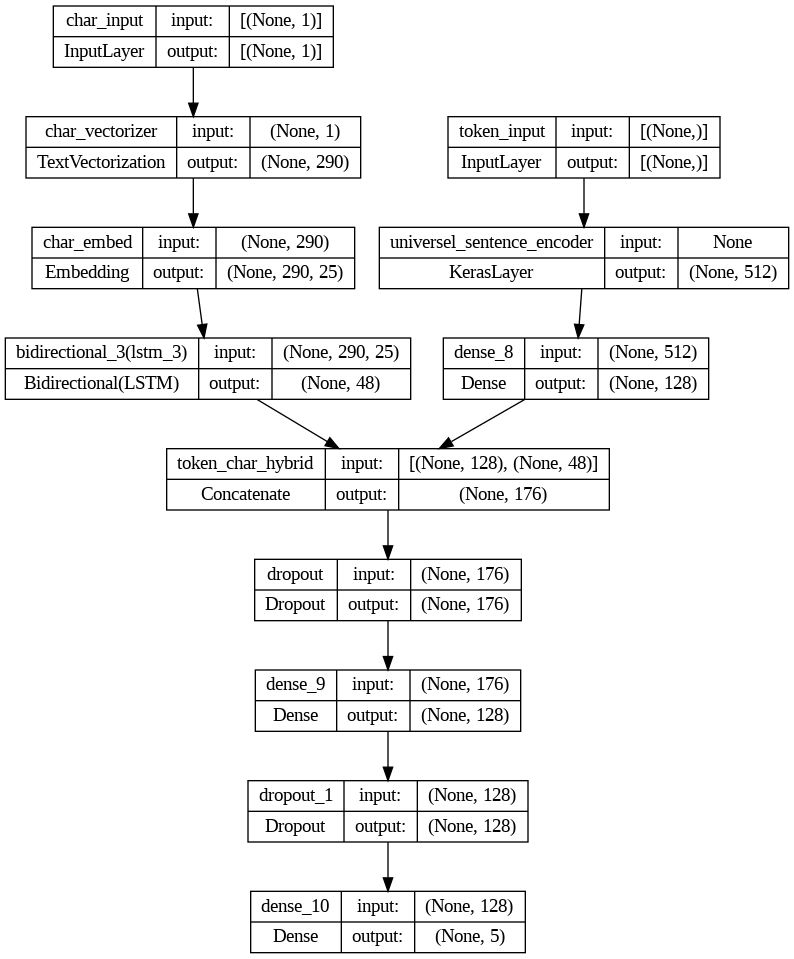

In [101]:
plot_model(model_4, show_shapes=True)

In [114]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [115]:
# combine chars & tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_list, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetch & batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [116]:
# combine chars & tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_list, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# prefetch & batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [118]:
 meta_4 = model_4.fit(train_char_token_dataset,
                      steps_per_epoch= int(0.1 * len(train_char_token_dataset)),
                      epochs=3,
                      validation_data=val_char_token_dataset,
                      validation_steps= int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 216s 365ms/step - loss: 0.9946 - accuracy: 0.6000 - val_loss: 0.7973 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 199s 354ms/step - loss: 0.8076 - accuracy: 0.6904 - val_loss: 0.7205 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 199s 354ms/step - loss: 0.7812 - accuracy: 0.7000 - val_loss: 0.6959 - val_accuracy: 0.7367


In [119]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 74s 78ms/step - loss: 0.7043 - accuracy: 0.7311


[0.70433509349823, 0.7311002016067505]

In [120]:
# Make predictions using the token-character hybrid model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs 

945/945 [==============================] - 74s 73ms/step


array([[4.5061427e-01, 3.3946609e-01, 3.6145563e-03, 2.0077468e-01,
        5.5302684e-03],
       [3.5425833e-01, 3.7671334e-01, 3.0926894e-03, 2.6310733e-01,
        2.8283452e-03],
       [2.4451977e-01, 7.8820661e-02, 4.5416903e-02, 6.1203796e-01,
        1.9204771e-02],
       ...,
       [7.8644376e-04, 1.2424701e-02, 4.4932399e-02, 3.5647437e-04,
        9.4150001e-01],
       [8.6705163e-03, 6.5382928e-02, 1.8677501e-01, 3.7713936e-03,
        7.3540014e-01],
       [2.7262294e-01, 4.3145606e-01, 2.3167580e-01, 2.1405514e-02,
        4.2839669e-02]], dtype=float32)

In [121]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [122]:
model_4_results = model_evaluation(val_label_encoded, model_4_preds)
model_4_results

{'accuracy': 73.11002250761287,
 'precision': 0.735738131097881,
 'recall': 0.7311002250761287,
 'f1': 0.7293049378867769}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [123]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [124]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

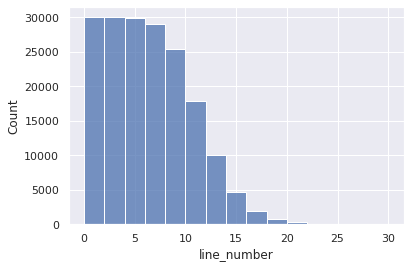

In [127]:
sns.histplot(data=train_df["line_number"], binwidth=2)

In [130]:
# using TensorFlow to one-hot encode the "line_number" column
train_line_number_one_hot = tf.one_hot(indices=train_df["line_number"], depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"], depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"], depth=15)

In [131]:
train_line_number_one_hot.shape

TensorShape([180040, 15])

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [132]:
# How many diffrent numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

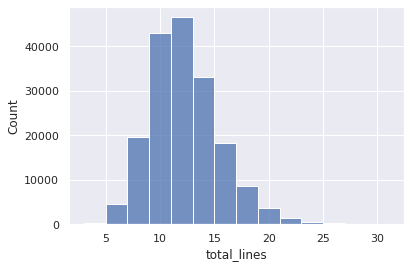

In [135]:
sns.histplot(data=train_df["total_lines"], binwidth=2)

In [136]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [137]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [144]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
tokenizer = tf_hub_embedding_layer(token_inputs)
token_outputs  = layers.Dense(128, activation="relu")(tokenizer)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. line_number inputs
line_num_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation='relu')(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs, x)

# 4. Total line inputs
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, y)

# 5. combine token & char embeddings into a hybrid model
hybrid_model = layers.Concatenate(name="char_token_hybrid_model")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(hybrid_model)
z = layers.Dropout(0.5)(z)

# 6. combine positional embedding with hybrid model(token-char model)
tribrid_model = layers.Concatenate(name="tribrid_model")([line_num_model.output,
                                                          total_line_model.output,
                                                          z])

# 7. output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_model)

# 8. put together with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_num_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs= output_layer,
                         name="model_5_tribrid_embedding_model")

In [145]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universel_sentence_encoder (Ke  (None, 512)         256797824   ['t

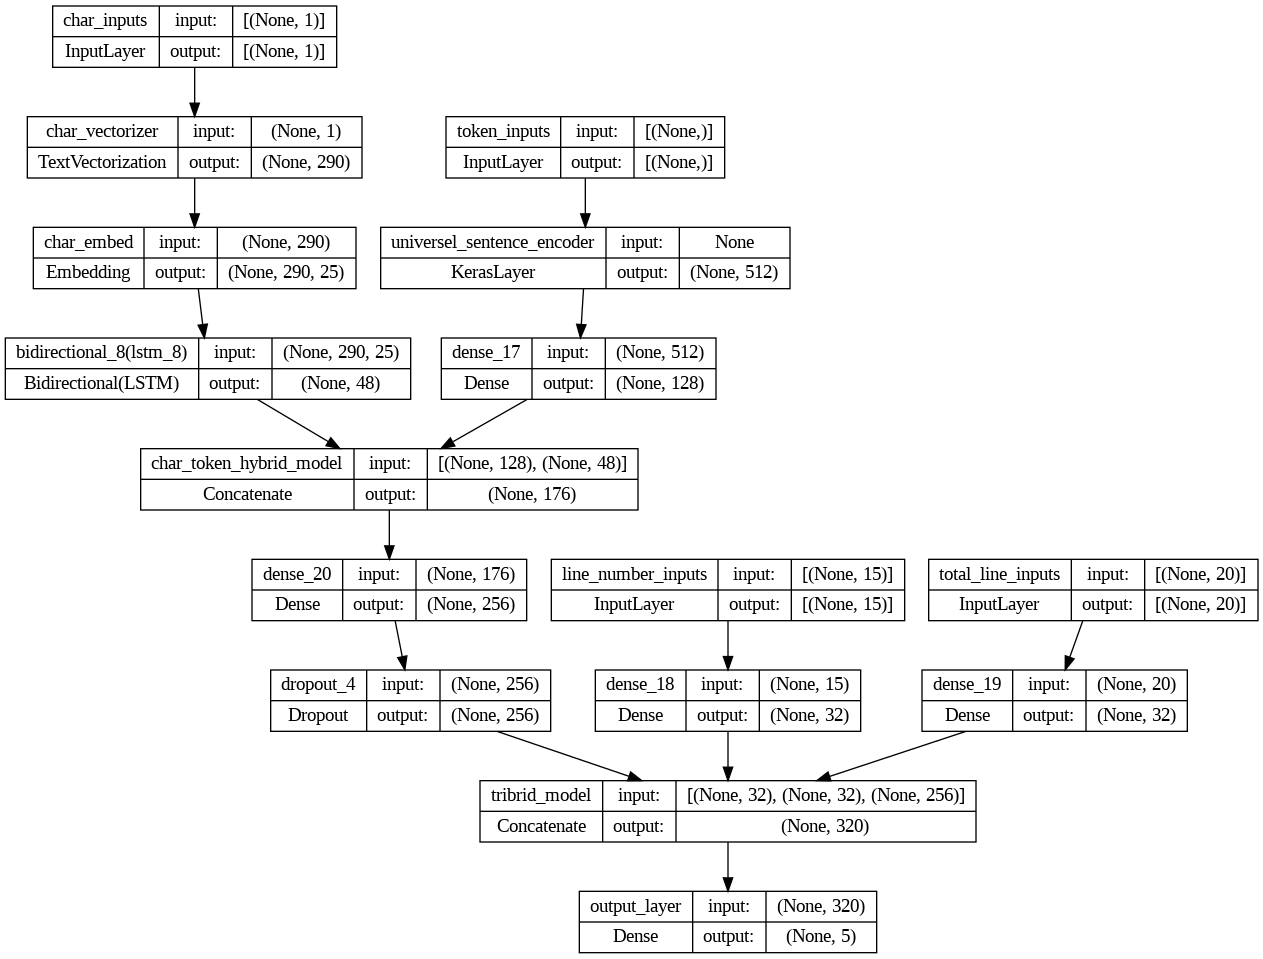

In [147]:
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` 

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> 📖 **Resource:** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [149]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [150]:
# create training datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_list,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [151]:
# create validation datasets
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_list,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [152]:
# check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predicitions with our tribrid model

In [153]:
meta_5 = model_5.fit(train_char_token_pos_dataset,
                     steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                     epochs=3,
                     validation_data=val_char_token_pos_dataset,
                     validation_steps=int(0.1*len(val_char_token_pos_dataset))) 

Epoch 1/3
562/562 [==============================] - 206s 344ms/step - loss: 1.0944 - accuracy: 0.7250 - val_loss: 0.9826 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 190s 338ms/step - loss: 0.9673 - accuracy: 0.8162 - val_loss: 0.9511 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 209s 372ms/step - loss: 0.9515 - accuracy: 0.8236 - val_loss: 0.9396 - val_accuracy: 0.8314


In [155]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 70s 74ms/step


array([[0.5039213 , 0.11500839, 0.00960768, 0.3551828 , 0.01627995],
       [0.5007104 , 0.10423312, 0.03322991, 0.3524481 , 0.00937842],
       [0.30073026, 0.11297144, 0.1183344 , 0.40835497, 0.05960902],
       ...,
       [0.03147497, 0.12181647, 0.04376652, 0.03619647, 0.7667456 ],
       [0.02838502, 0.2929418 , 0.07097926, 0.02824054, 0.5794534 ],
       [0.20268282, 0.56444263, 0.11750107, 0.04131263, 0.0740609 ]],
      dtype=float32)

In [156]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [158]:
model_5_results = model_evaluation(val_label_encoded, model_5_preds)
model_5_results

{'accuracy': 83.28478750165496,
 'precision': 0.8315901932975639,
 'recall': 0.8328478750165497,
 'f1': 0.8319420037716944}

## Compare model results

In [164]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": model_0_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.687277,0.784314,0.786873,0.784473
model_2_pretrained_token_embedding,71.385542,0.714450,0.713855,0.711051
model_3_custom_char_embedding,44.945717,0.378165,0.449457,0.394916
model_4_hybrid_char_token_embedding,73.110023,0.735738,0.731100,0.729305
model_5_pos_char_token_embedding,83.284788,0.831590,0.832848,0.831942


In [165]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

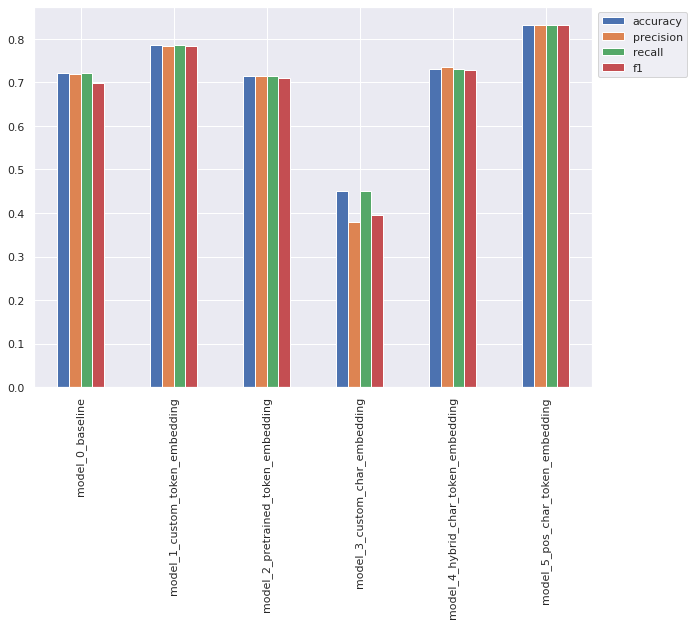

In [168]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

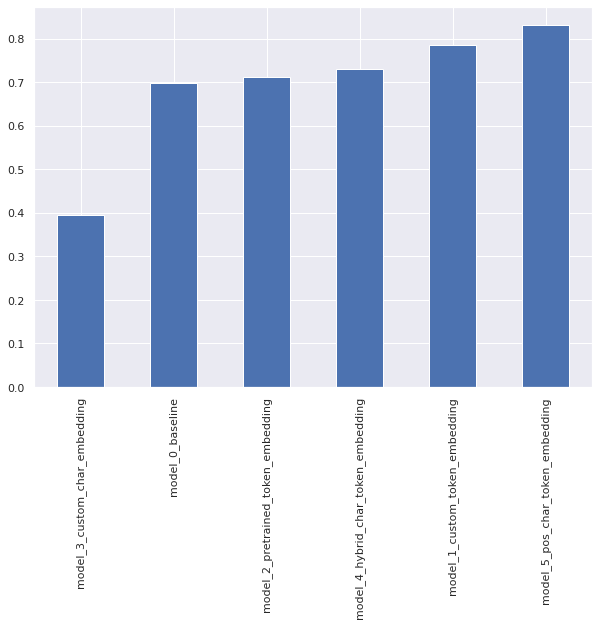

In [169]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load model 

In [ ]:
# Save the best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded moel on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.36422613531047,
 'f1': 0.832856749242421,
 'precision': 0.8329936901758904,
 'recall': 0.8336422613531047}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

## Download and load in a pretrained model from Google Storage

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-04-22 05:16:26--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.12.240, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M   257MB/s    in 3.6s    

2021-04-22 05:16:30 (258 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  

In [ ]:
# Load in downloaded Google Storage model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

In [ ]:
# Evalaute the loaded Google Storage model
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 22ms/step - loss: 0.9459 - accuracy: 0.8283


[0.9459028244018555, 0.8283132314682007]

## Your challenges

Try these out before moving onto the next module.

The GitHub has an example of how to do each but I'd encourage you to try it for yourself first (you've got this!).

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json 
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09) 

> See the full course materials (including an example of how to do the above) on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning